# 06-03: The Friendship Paradox

*November 23 2022*  

In the third notebook, we explore the friendship paradox in random and empirical networks.

In [1]:
import pathpy as pp
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use('default')
sns.set_style("whitegrid")

C:\Users\ingos\Anaconda3\lib\site-packages\pandas\compat\_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.9' currently installed).
  warnings.warn(msg, UserWarning)


C:\Users\ingos\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# The Friendship Paradox

We first use pathpy to recover the values regarding the friendship paradox that we presented in the theory lecture. For this we load the network `lotr` from the database.

In [3]:
n = pp.io.sql.read_network('../data/networks.db', sql='SELECT DISTINCT source, target FROM lotr',directed=False)
print(n)
n

[12-01 00:09:22: WARNING] 67 edges existed already and were not be considered. To capture those edges, consider creating a multiedge and/or directed network.


Uid:			0x275f902cf60
Type:			Network
Directed:		False
Multi-Edges:		False
Number of nodes:	139
Number of edges:	634


We first study the friendship paradox at the local level, i.e. at the level of a single node. We pick the character `Tom` and calculate how many friends `Tom` has, i.e. the degree of Tom. We then calculate how many friends the friends of `Tom` have on average:

In [4]:
v = "Tom"
n_friends = n.degrees()[v]
n_friendsfriends = 0
for w in n.successors[v]:
    n_friendsfriends += n.degrees()[w.uid]

print("{} has {} friends: {}:".format(v, n_friends, [f.uid for f in n.successors[v]]))
print("{}'s friends have {:2.1f} friends on average.".format(v, n_friendsfriends/n_friends))

Tom has 9 friends: ['Sam', 'Bilbo', 'Elrond', 'Frodo', 'Galadriel', 'Gandalf', 'Goldberry', 'Butterbur', 'Merry']:
Tom's friends have 27.3 friends on average.


For this specific node we observe the so-called **friendship paradox**, which states that your friends have on average more friends than you. It is called "paradox" because intuition might suggest that we are not different from our friends in terms of the degree. Let us test this paradox at the level of the whole network. For this we compare the mean degree in the network with the mean neighbour degree. 

Using `pathpy` we can compute the mean degree in two ways:

In [5]:
print("<k>   = ", np.mean(n.degree_raw_moment(k=1)))
print("<k>   = ", np.mean(n.mean_degree()))

<k>   =  9.122302158273385
<k>   =  9.122302158273381


For each node $v$ we calculate the mean degree $k_n$ of their neighbours. We then compare the average $\langle k_n \rangle$ across all nodes $v$ to the mean degree $\langle k \rangle$ calculated above.

In [6]:
ndegrees = {}

for v in n.nodes:
    knn = 0
    d_v = n.degrees()[v.uid]

    for w in n.successors[v.uid]:
        knn += n.degrees()[w.uid]

    if d_v>0:
        ndegrees[v.uid]= knn/d_v

print("<k_n> = ", np.mean(list(ndegrees.values())))

<k_n> =  20.01356175330297


Let us compare this to the result of the function `mean_neighbor_degree()` in `pathpy`

In [7]:
print("<k_n> = ", np.mean(n.mean_neighbor_degree()))

<k_n> =  19.402208201892744


We find a different value because we can calculate the mean neighbour degree in different ways. Above, we have averaged the degrees of the neighbors of each node, which gives a value for each node in the network. We have then averaged those averages to obtain a single value for the whole network. This effectively calculates a double average. We can alternatively calculate all neigbour degrees for all nodes, and the compute a single average for the network, which is what we do in `pathpy`. Let us confirm this:

In [8]:
n_degrees = []

for v in n.nodes:
    d_v = n.degrees()[v.uid]
    for w in n.successors[v.uid]:
        n_degrees.append(n.degrees()[w.uid])

print("<k_n> = ", np.mean(n_degrees))

<k_n> =  19.402208201892744


We find a value that is considerably larger than the average degree of 9.12. We thus observe a friendship paradox in this network. Nevertheless, we may find some nodes in the network for whom the paradox does *not* hold. In the following we study for which nodes the number of friends ($k$) is smaller than the average number ($k_n$) of direct friends that their friends have?

To answer this question, we use the following helper function. It produces the same plot that you have seen in L06. It shows the degrees of all nodes on the x-axis, with the corresponding mean neighbour degrees on the y-axis. We further count for how many nodes in this network the friendship paradox holds, i.e. for how many nodes we have $k_n>k$. We finally output those nodes for which the paradox does not hold.

Number of nodes for which k_n > k = 120
Number of nodes for which k_n < k = 14


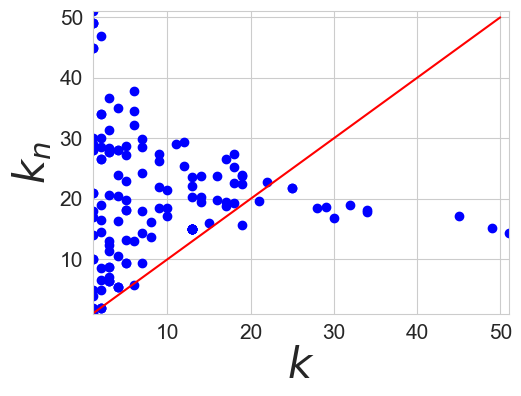

In [9]:
def plotNeighbourDegrees(n):
    degrees = []
    ndegrees = []
    
    larger = []
    smaller = []
    for v in n.nodes:
        knn = 0
        for w in n.successors[v.uid]:
            knn += n.degrees()[w.uid]
        degrees.append(n.degrees()[v.uid])
        
        if n.degrees()[v.uid]>0:
            nd = knn/n.degrees()[v.uid]
            if nd > n.degrees()[v.uid]:
                larger.append(v.uid)
            elif nd < n.degrees()[v.uid]:
                smaller.append(v.uid)
            ndegrees.append(nd)
        else:
            ndegrees.append(0)
            
    print("Number of nodes for which k_n > k =", len(larger))
    print("Number of nodes for which k_n < k =", len(smaller))
    
    plt.clf()
    plt.grid(True)
    plt.tick_params(axis='both', which='major', labelsize=15)
    plt.xlim([min(pp.statistics.degree_sequence(n)), max(pp.statistics.degree_sequence(n))])
    plt.ylim([min(pp.statistics.degree_sequence(n)), max(pp.statistics.degree_sequence(n))])
    plt.xlabel('$k$', fontsize=30)
    plt.ylabel('$k_n$', fontsize=30)
    plt.subplots_adjust(bottom=0.25)
    plt.subplots_adjust(left=0.25)
    plt.plot(degrees, ndegrees, 'bo')
    plt.plot(range(int(max(pp.statistics.degree_sequence(n)))), range(int(max(pp.statistics.degree_sequence(n)))), 'r-')
    plt.show()
    return larger, smaller

larger, smaller = plotNeighbourDegrees(n)

Print the names of those characters that have more friends than their friends have on average.

In [10]:
print(smaller)

['Merry', 'Gandalf', 'Bilbo', 'Elrond', 'Frodo', 'Aragorn', 'Faramir', 'Pippin', 'Sam', 'Théoden', 'Helm', 'Gimli', 'Legolas', 'Grimbold']


# Friendship paradox in Random Graphs

Is the friendship paradox in this network due to the specific topology, i.e. does it depend on which nodes are connected to each other? We can test this by randomizing the network based on the Molloy-Reed model, i.e. we can fix the degree sequence of the empirical network as a macrostate and generate a random microstate consistent with that microstate. For this, we can use the Molloy-Reed randomization function in `pathpy`, which allows us to create a random realization of a network with the same degree sequence as a given network instance. Note that the mapping between nodes and node degrees is maintained as well.

In [12]:
n_r = pp.generators.Molloy_Reed_randomize(n)

print("<k_n> = ", np.mean(n_r.mean_neighbor_degree()))
print("<k> = ", np.mean(n_r.mean_degree()))

<k_n> =  19.402208201892744
<k> =  9.122302158273381


We see that the friendship paradox still holds in this random microstate, which suggests that the paradox is due to the degree sequence rather than the specific topology. Let us check how the plot from above looks like now, and let us output the nodes for which the neighbors have - on average - smaller degree than themselves:

Number of nodes for which k_n > k = 125
Number of nodes for which k_n < k = 14


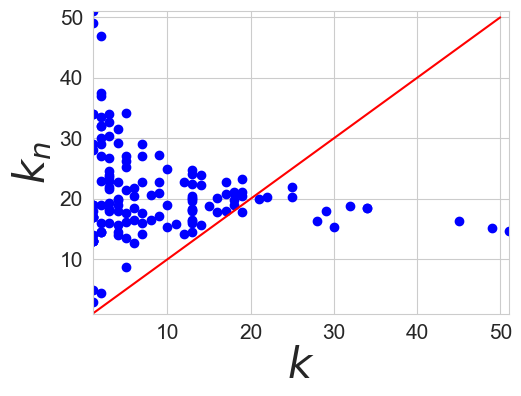

['Merry', 'Gandalf', 'Bilbo', 'Elrond', 'Frodo', 'Aragorn', 'Peregrin', 'Faramir', 'Pippin', 'Sam', 'Théoden', 'Helm', 'Gimli', 'Legolas']


In [13]:
larger, smaller = plotNeighbourDegrees(n_r)
print(smaller)

In a previous practice session, we found that the degree distribution of the network above is different from the expected (Binomial) degree distribution of an Erdös-Renyi random graph model. But does the friendship paradox depend on this specific degree distribution or does it also hold for random graphs? Let us test this:

In [21]:
n = pp.generators.ER_np(n=2000, p=2/2000)
k = n.mean_degree()
kn = n.mean_neighbor_degree()
print("<k> = ", k)
print("<k_n> = ", kn)
print("<k_n> - <k>", kn-k)

generating G(n,p) network: 100%|██████████| 2000/2000 [00:00<00:00, 2215.28it/s]


<k> =  2.111
<k_n> =  3.0720037896731407
<k_n> - <k> 0.9610037896731405


In [22]:
n = pp.generators.ER_np(n=2000, p=3/2000)
k = n.mean_degree()
kn = n.mean_neighbor_degree()
print("<k> = ", k)
print("<k_n> = ", kn)
print("<k_n> - <k>", kn-k)

generating G(n,p) network: 100%|██████████| 2000/2000 [00:00<00:00, 2022.45it/s]


<k> =  2.939
<k_n> =  3.93841442667574
<k_n> - <k> 0.9994144266757399


In [23]:
n = pp.generators.ER_np(n=2000, p=5/2000)
k = n.mean_degree()
kn = n.mean_neighbor_degree()
print("<k> = ", k)
print("<k_n> = ", kn)
print("<k_n> - <k>", kn-k)

generating G(n,p) network: 100%|██████████| 2000/2000 [00:01<00:00, 1288.32it/s]


<k> =  5.006
<k_n> =  5.948861366360368
<k_n> - <k> 0.9428613663603675


We find that the difference between the mean neighbour degree and the mean degree is much smaller than before and independent of the connection probability and the mean degree, it is actually close to one. If we do not account for the link (v,w) when calculating the degree of neighbour w of node v, we actually get the same value for both. We can calculate the mean neighbour degree of neighbours $w$ of $v$ without counting the link $(v,w)$ as follows:

In [24]:
kn = n.mean_neighbor_degree(exclude_neighbor=True)
print("<k> = ", k)
print("<k_n> = ", kn)
print("<k_n> - <k>", kn-k)

<k> =  5.006
<k_n> =  4.948861366360368
<k_n> - <k> -0.05713863363963245


Clearly, the friendship paradox cannot apply in networks where all degrees are exactly the same. We can create such a $k$-regular network by applying the Molloy-Reed configuration algorithm to a sequence that consists of a single repeated degree:

In [16]:
n = pp.generators.Molloy_Reed([2]*100)
k = n.mean_degree()
kn = n.mean_neighbor_degree()
print("<k> = ", k)
print("<k_n> = ", kn)
print("<k_n> - <k>", kn-k)

<k> =  2.0
<k_n> =  2.0
<k_n> - <k> 0.0


For random $G(n,p)$ networks with a Binomial degree distribution we have found that the parameter $p$ of the model does not influence the strength of the friendship paradox. But what about other degree distributions? Let us try this for networks with a given Normal distribution, where we can control the mean and the variance of the distribution.

In [25]:
degrees = [1]
while not pp.generators.is_graphic_Erdos_Gallai(degrees):
    degrees = [int(x) for x in np.random.normal(2, 0.5, 300)]
n = pp.generators.Molloy_Reed(degrees)
k = n.mean_degree()
kn = n.mean_neighbor_degree()
print("<k> =\t\t", k)
print("<k_n> =\t\t", kn)
print("<k_n>-<k> =\t", kn-k)

<k> =		 1.4866666666666666
<k_n> =		 1.7085201793721974
<k_n>-<k> =	 0.22185351270553078


Let us first increase the mean degree while keeping the variance constant. Interestingly this decreases the strength of the friendship paradox:

In [27]:
degrees = [1]
while not pp.generators.is_graphic_Erdos_Gallai(degrees):
    degrees = [int(x) for x in np.random.normal(3, 0.5, 300)]
n = pp.generators.Molloy_Reed(degrees)
k = n.mean_degree()
kn = n.mean_neighbor_degree()
print("<k> =\t\t", k)
print("<k_n> =\t\t", kn)
print("<k_n>-<k> =\t", kn-k)

<k> =		 2.5
<k_n> =		 2.64
<k_n>-<k> =	 0.14000000000000012


If we increase the variance while keeping the mean degree constant we find that the strength of the friendship paradox actually increases:

In [28]:
degrees = [1]
while not pp.generators.is_graphic_Erdos_Gallai(degrees):
    degrees = [int(x) for x in np.random.normal(3, 1, 300)]
n = pp.generators.Molloy_Reed(degrees)
k = n.mean_degree()
kn = n.mean_neighbor_degree()
print("<k> =\t\t", k)
print("<k_n> =\t\t", kn)
print("<k_n>-<k> =\t", kn-k)

<k> =		 2.513333333333333
<k_n> =		 2.9124668435013263
<k_n>-<k> =	 0.39913351016799314


Next week, we will analytically explain those observations based on generating functions, which we can use to encode properties of degree distributions of random networks.